In [1]:
import sys
import datetime as dt
from copy import deepcopy
from os import getcwd
from os.path import dirname, join

import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from scipy import interpolate
import pytz

PROJ_DIR = dirname(getcwd())
sys.path.append(PROJ_DIR)

SRC_DIR = join(PROJ_DIR, 'MAMMAL')
DATA_DIR = join(PROJ_DIR, 'data')
TEST_DIR = join(DATA_DIR, 'test')

import MAMMAL
from MAMMAL.Utils import mapUtils as mu
from MAMMAL.Utils import ProcessingUtils as pu


%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # (w, h)
pd.set_option('mode.chained_assignment', None)


SGL_CORDS_FNAME  = join(TEST_DIR, 'CORDS-Road_MAG-asc.gxf')            # Cords Road: 300m MSL (map is level)
SGL_MEDIUM_FNAME = join(TEST_DIR, 'R2508-Medium-Altitude_MAG-asc.gxf') # Medium altitude: 7000m MSL (map is level)
SGL_CAP_FNAME    = join(TEST_DIR, 'R2508-Cap_MAG-asc.gxf')             # Cap altitude: 17000m MSL (map is level)

USGS_SURVEY_NAME  = 'TRONA'
USGS_SURVEY_FNAME = 'trona_mag.xyz'
USGS_SURVEY_PATH  = join(join(TEST_DIR, USGS_SURVEY_NAME), USGS_SURVEY_FNAME)

Text(0.5, 1.0, 'SGL Cap Altitude Map')

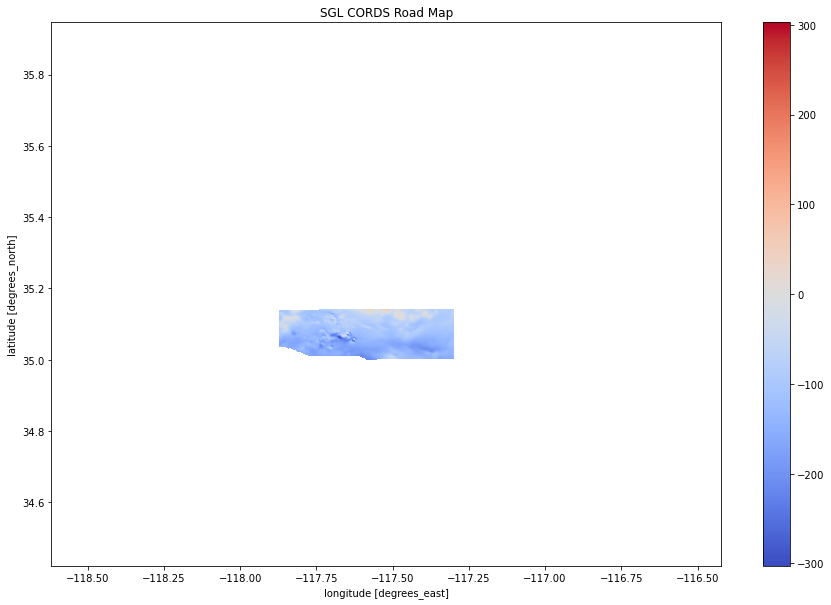

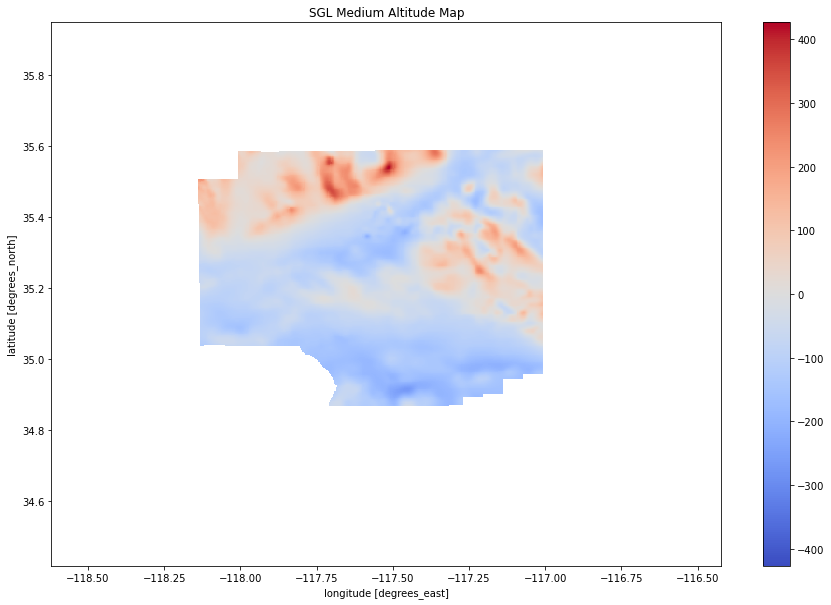

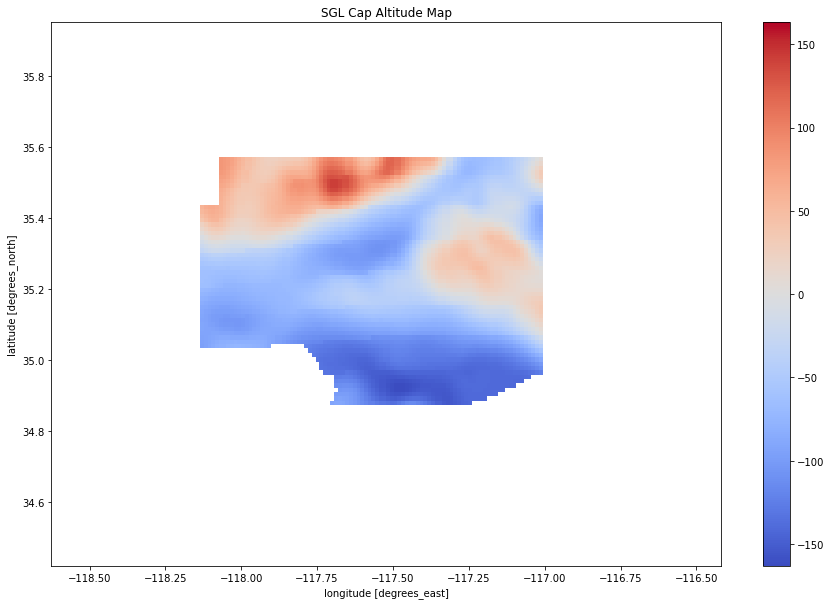

In [2]:
SGL_cords_map  = rxr.open_rasterio(SGL_CORDS_FNAME,  masked=True, decode_coords='all').rio.reproject("EPSG:4326")
SGL_medium_map = rxr.open_rasterio(SGL_MEDIUM_FNAME, masked=True, decode_coords='all').rio.reproject("EPSG:4326")
SGL_cap_map    = rxr.open_rasterio(SGL_CAP_FNAME,    masked=True, decode_coords='all').rio.reproject("EPSG:4326")

plt.figure()
SGL_cords_map.plot(cmap=cm.coolwarm)
plt.title('SGL CORDS Road Map')

plt.figure()
SGL_medium_map.plot(cmap=cm.coolwarm)
plt.title('SGL Medium Altitude Map')

plt.figure()
SGL_cap_map.plot(cmap=cm.coolwarm)
plt.title('SGL Cap Altitude Map')

In [3]:
buffer = 0.01

SGL_max_lat = max(SGL_cords_map.y.max().item(),
                  SGL_medium_map.y.max().item(),
                  SGL_cap_map.y.max().item())
SGL_min_lat = min(SGL_cords_map.y.min().item(),
                  SGL_medium_map.y.min().item(),
                  SGL_cap_map.y.min().item())

SGL_max_lon = max(SGL_cords_map.x.max().item(),
                  SGL_medium_map.x.max().item(),
                  SGL_cap_map.x.max().item())
SGL_min_lon = min(SGL_cords_map.x.min().item(),
                  SGL_medium_map.x.min().item(),
                  SGL_cap_map.x.min().item())

SGL_extent = [SGL_min_lon, # left
              SGL_max_lon, # right
              SGL_min_lat, # bottom
              SGL_max_lat] # top

USGS_max_lat = SGL_max_lat + buffer
USGS_min_lat = SGL_min_lat - buffer

USGS_max_lon = SGL_max_lon + buffer
USGS_min_lon = SGL_min_lon - buffer

USGS_extent = [USGS_min_lon, # left
               USGS_max_lon, # right
               USGS_min_lat, # bottom
               USGS_max_lat] # top

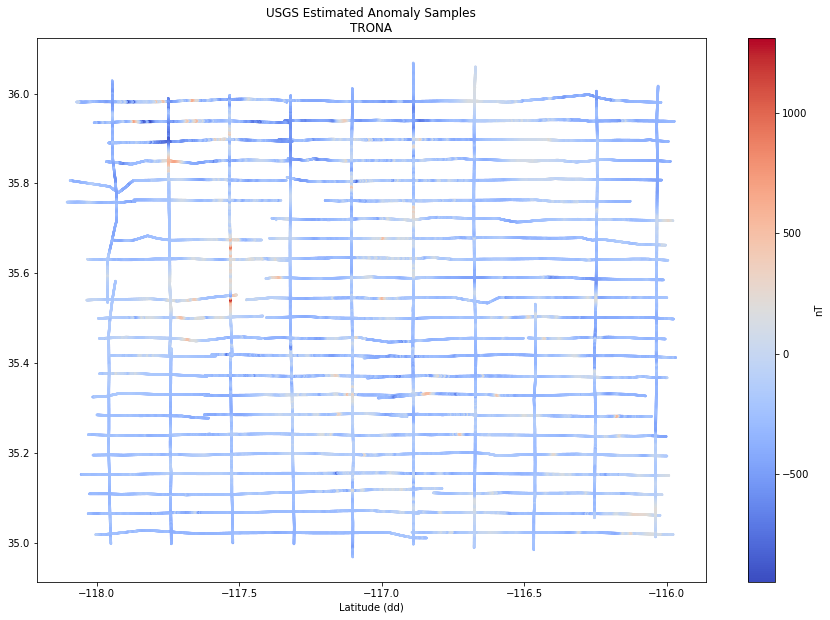

In [4]:
USGS_df = pd.read_csv(USGS_SURVEY_PATH,
                      delim_whitespace=True,
                      na_values=-9999.9,
                      names=['line',
                             'fid',
                             'time',
                             'day',
                             'year',
                             'latitude',
                             'longitude',
                             'radalt' ,
                             'totmag',
                             'resmag',
                             'diurnal',
                             'geology',
                             'resmagCM4'])

plt.figure()
plt.title('USGS Estimated Anomaly Samples\n{}'.format(USGS_SURVEY_NAME))
plt.scatter(USGS_df.longitude,
            USGS_df.latitude,
            c=USGS_df.resmag, s=2, cmap=cm.coolwarm)
plt.xlabel('Longitude (dd)')
plt.xlabel('Latitude (dd)')
plt.colorbar(label='nT')

In [5]:
USGS_df = USGS_df.drop(columns='diurnal')
USGS_df = USGS_df.dropna()

USGS_df.rename(columns={'resmag':    'F',
                        'latitude':  'LAT',
                        'longitude': 'LONG',
                        'line':      'LINE'},
               inplace=True)

USGS_df['ALT']       = 0
USGS_df['LINE_TYPE'] = 1
USGS_df.LINE_TYPE[USGS_df.LINE >= 5000] = 2

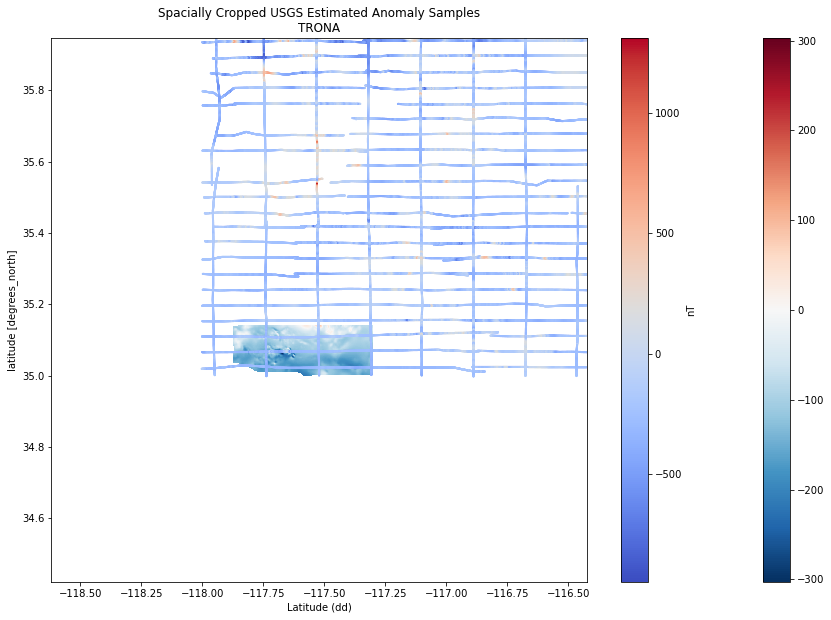

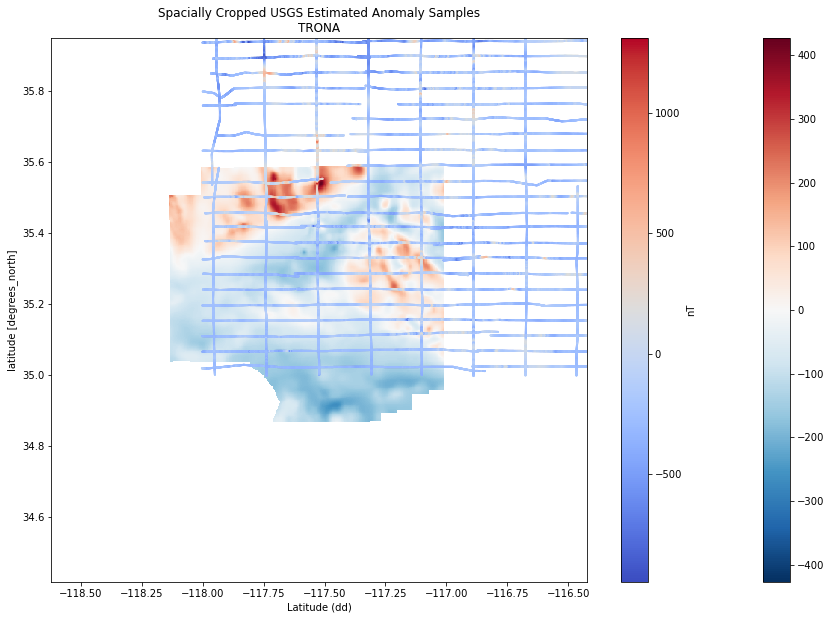

In [6]:
USGS_df = USGS_df[(USGS_df.LAT  <= USGS_max_lat) & (USGS_df.LAT  >= USGS_min_lat) & \
                  (USGS_df.LONG <= USGS_max_lon) & (USGS_df.LONG >= USGS_min_lon)]

plt.figure()
SGL_cords_map.plot()

plt.title('Spacially Cropped USGS Estimated Anomaly Samples\n{}'.format(USGS_SURVEY_NAME))
plt.scatter(USGS_df.LONG,
            USGS_df.LAT,
            c=USGS_df.F, s=1, cmap=cm.coolwarm)
plt.xlabel('Longitude (dd)')
plt.xlabel('Latitude (dd)')
plt.colorbar(label='nT')

plt.figure()
SGL_medium_map.plot()

plt.title('Spacially Cropped USGS Estimated Anomaly Samples\n{}'.format(USGS_SURVEY_NAME))
plt.scatter(USGS_df.LONG,
            USGS_df.LAT,
            c=USGS_df.F, s=1, cmap=cm.coolwarm)
plt.xlabel('Longitude (dd)')
plt.xlabel('Latitude (dd)')
plt.colorbar(label='nT')

Interpolating survey anomaly data to map coordinates
Running bicubic spline interpolation for all map pixels


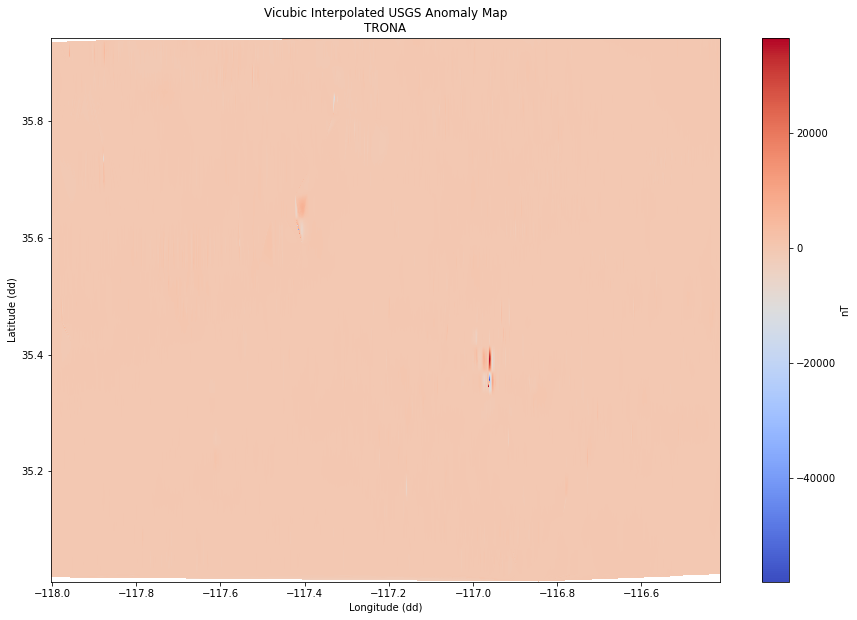

In [9]:
USGS_interp_dict = pu.interp_flight_lines(anomaly_df      = USGS_df,
                                          dx              = 100,
                                          dy              = 100,
                                          max_terrain_msl = 0,
                                          interp_type     = 'bicubic',
                                          skip_na_mask    = True)

plt.figure()
plt.title('Vicubic Interpolated USGS Anomaly Map\n{}'.format(USGS_SURVEY_NAME))
plt.pcolormesh(USGS_interp_dict['LONG'],
               USGS_interp_dict['LAT'],
               USGS_interp_dict['F'], cmap=cm.coolwarm)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.colorbar(label='nT')